In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from os.path import expanduser
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)
test_labels = pd.read_csv('test_labels.csv',index_col=0)
print(test_labels.head())
labelled_test = test.join(test_labels)
disclosed = labelled_test.toxic>-1
print(disclosed .mean(),'% of test is labelled')
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]
print(train.shape,test.shape)
train.to_csv('tc_train.csv')
test.to_csv('tc_test.csv')

                  toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1
0.41770912224804785 % of test is labelled
(223549, 7) (89186, 1)


In [6]:
train = pd.read_csv('tc_train.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.shape

(223549, 7)

In [8]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [9]:
train.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

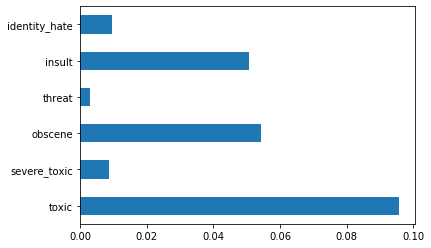

In [10]:
train[types].mean().plot(kind='barh')

In [11]:
for t in types:
    print('\n','*'*10+(t+' comments').upper()+'*'*10,'\n')
    for c in train.comment_text[train[t]==1][:3]:
        print(c)
        print('---- comment end ----')


 **********TOXIC COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
---- comment end ----
Bye! 

Don't look, come or think of comming back! Tosser.
---- comment end ----

 **********SEVERE_TOXIC COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
---- comment end ----
you are a stupid fuck 

and your mother's cunt stinks
---- comment end ----

 **********OBSCENE COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Gr

In [2]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index

embeddings_index = get_embeddings('crawl-300d-2M.vec')

In [12]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

train['comment_clean'] = train.comment_text.apply(preprocess)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_clean
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww he matches this background colour i'm s...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it...
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on im...
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember...


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)
vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train.comment_clean)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
45259 top words


In [14]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train.comment_clean)
print(tokenizer)

In [15]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

280518


[('the', 1),
 ('to', 2),
 ('of', 3),
 ('and', 4),
 ('a', 5),
 ('you', 6),
 ('i', 7),
 ('is', 8),
 ('that', 9),
 ('in', 10),
 ('it', 11),
 ('for', 12),
 ('this', 13),
 ('not', 14),
 ('on', 15),
 ('be', 16)]

In [16]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train.comment_clean)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('comments.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[676, 77, 1, 133, 130, 177, 30, 666, 4436, 11406, 1126, 85, 349, 51, 2184, 12587, 50, 6354, 15, 59, 2567, 148, 7, 2795, 33, 116, 1196, 15967, 2453, 4, 47, 60, 247, 1, 359, 31, 1, 41, 27, 143, 71, 3503, 89], [121402, 52, 2765, 13, 466, 3656, 71, 4530, 2696, 21, 93, 41, 968, 196]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  676    77     1   133   130   177    30   666  4436 11406  1126    85
   349    51  2184 12587    50  6354    15    59  2567   148     7  2795
    33   116  1196 15967  2453     4    47    60   247     1   359    31
     1    41    27   143    71  3503    89     0     0     0     0     0
     0     0]


In [17]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [18]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [19]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = 'toxic_comments_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

160113 unknown words


In [20]:
# convert each vector of labels to the string
labels = train[types].astype(str).apply(lambda x: ''.join(x),axis=1)
print('Labels: \n',labels.head())
# aggregate rare combinations if any
count = labels.value_counts()
rare = count.index[count<=2]
labels[np.isin(labels.values,rare)] = 'rare'
print('\nCounts of labels: \n',labels.value_counts())
train_index, val_index = train_test_split(list(range(data.shape[0])), test_size=0.2, 
                                      stratify = labels, random_state=0)
# save train and validation indices for further calculations
fname = 'train_val_split.pkl'
with open(fname, 'wb') as f: pickle.dump([train_index, val_index], f, -1)

Labels: 
 id
0000997932d777bf    000000
000103f0d9cfb60f    000000
000113f07ec002fd    000000
0001b41b1c6bb37e    000000
0001d958c54c6e35    000000
dtype: object

Counts of labels: 
 000000    201081
100000      7376
101010      5732
101000      2612
100010      1754
111010      1165
101011       979
111011       381
001000       366
000010       365
100011       215
100001       203
101110       196
001010       196
111000       186
100100       163
111110        88
101111        81
000001        68
101001        55
111111        45
110000        41
000011        32
000100        27
100110        25
001011        19
101100        17
110010        14
110100        11
100101        11
111100         8
111001         7
110011         7
110101         5
rare           5
000110         4
100111         3
001001         3
110001         3
dtype: int64


In [22]:
def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(10, return_sequences=True)(x)
    x = Conv1D(5, kernel_size=2, padding="valid")(x)
    x = GlobalMaxPooling1D()(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=Adam())
    return model

In [23]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)
with open('comments.pkl', 'rb') as f: data = pickle.load(f)   

X_train = data[train_index]
X_val = data[val_index]

y_train = train.iloc[train_index][['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
y_val = train.iloc[val_index][['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [24]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)

model = get_model()
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           84155700  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 10)            12440     
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 5)             105       
_________________________________________________________________
global_max_pooling1d (Global (None, 5)                 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5)                

In [54]:
hist = model.fit(X_train, y_train,validation_data=(X_val, y_val),
                 epochs=100, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)
val_pred = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_val, val_pred))

Epoch 1/100
350/350 - 28s - loss: 0.0648 - val_loss: 0.0538
Epoch 2/100
350/350 - 26s - loss: 0.0645 - val_loss: 0.0536
Epoch 3/100
350/350 - 28s - loss: 0.0641 - val_loss: 0.0531
Epoch 4/100
350/350 - 29s - loss: 0.0633 - val_loss: 0.0531
Epoch 5/100
350/350 - 28s - loss: 0.0628 - val_loss: 0.0529
Epoch 6/100
350/350 - 28s - loss: 0.0621 - val_loss: 0.0536
Epoch 7/100
350/350 - 28s - loss: 0.0618 - val_loss: 0.0527
Epoch 8/100
350/350 - 29s - loss: 0.0612 - val_loss: 0.0525
Epoch 9/100
350/350 - 29s - loss: 0.0604 - val_loss: 0.0525
Epoch 10/100
350/350 - 28s - loss: 0.0601 - val_loss: 0.0525
Epoch 11/100
350/350 - 28s - loss: 0.0595 - val_loss: 0.0524
Epoch 12/100
350/350 - 28s - loss: 0.0595 - val_loss: 0.0517
Epoch 13/100
350/350 - 28s - loss: 0.0593 - val_loss: 0.0518
Epoch 14/100
350/350 - 28s - loss: 0.0589 - val_loss: 0.0517
Epoch 15/100
350/350 - 28s - loss: 0.0583 - val_loss: 0.0521
Epoch 16/100
350/350 - 28s - loss: 0.0580 - val_loss: 0.0515
Epoch 17/100
350/350 - 29s - loss

In [55]:
test = pd.read_csv('tc_test.csv',index_col=0)
print(test.shape)
test.head()

(89186, 1)


,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [36]:
test.columns

Index(['comment_text'], dtype='object')

In [56]:
test['comment_clean'] = test.comment_text.apply(preprocess)

In [57]:
test_seq = tokenizer.texts_to_sequences(test.comment_clean)
test_data = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                         truncating='post')
with open('test_comments.pkl','wb') as f: pickle.dump(data, f, -1)


In [58]:
test_pred = model.predict(test_data, batch_size=BATCH_SIZE, verbose=0)

In [40]:
test_pred

array([[9.46724236e-01, 4.46123391e-01, 9.24213469e-01, 1.82200134e-01,
        8.91353726e-01, 3.87172103e-01],
       [6.25431538e-04, 3.29301729e-05, 5.84352638e-05, 6.94514601e-05,
        9.59684985e-05, 5.94568955e-05],
       [3.67671251e-04, 4.13052257e-05, 3.94473391e-05, 1.20243414e-04,
        6.90096931e-05, 7.77454552e-05],
       ...,
       [5.98579645e-04, 4.06227555e-05, 5.88466974e-05, 9.87384774e-05,
        1.24692917e-04, 7.38880481e-05],
       [9.35882330e-04, 7.37655428e-05, 1.05456573e-04, 1.59978867e-04,
        1.92344189e-04, 1.29759312e-04],
       [7.11458325e-01, 3.01536322e-02, 4.71978396e-01, 9.70825553e-03,
        4.02154744e-01, 2.35576034e-02]], dtype=float32)

In [59]:
out = pd.DataFrame(test_pred, index=test.index)
out.columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']


In [60]:
out.shape

(89186, 6)

In [52]:
out.index

Index(['00001cee341fdb12', '0000247867823ef7', '00013b17ad220c46',
       '00017563c3f7919a', '00017695ad8997eb', '00024115d4cbde0f',
       '00025358d4737918', '00026d1092fe71cc', '0002eadc3b301559',
       '0003806b11932181',
       ...
       'fff8ef316d0c6990', 'fff9fa508f400ee6', 'fffa3fae1890b40a',
       'fffc2b34bbe61c8d', 'fffc489742ffe69b', 'fffcd0960ee309b5',
       'fffd7a9a6eb32c16', 'fffda9e8d6fafa9e', 'fffe8f1340a79fc2',
       'ffffce3fb183ee80'],
      dtype='object', name='id', length=89186)

In [ ]:
out.head()

In [61]:
out.to_csv('tc_output.csv')

In [38]:
test.shape

(89186, 2)

In [40]:
train.shape

(223549, 8)

In [41]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_clean
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww he matches this background colour i'm s...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it...
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on im...
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember...


In [42]:
test.head()

,comment_text,comment_clean
id,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is ...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland...
00017563c3f7919a,":If you have a look back at the source, the in...",if you have a look back at the source the in...
00017695ad8997eb,I don't anonymously edit articles at all.,i don't anonymously edit articles at all


In [47]:
out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,00001cee341fdb12,0.946724,0.446123,0.924213,0.182200,0.891354,0.387172
0000247867823ef7,0000247867823ef7,0.000625,0.000033,0.000058,0.000069,0.000096,0.000059
00013b17ad220c46,00013b17ad220c46,0.000368,0.000041,0.000039,0.000120,0.000069,0.000078
00017563c3f7919a,00017563c3f7919a,0.007346,0.000357,0.001026,0.000452,0.001548,0.000561
00017695ad8997eb,00017695ad8997eb,0.002432,0.000178,0.000330,0.000327,0.000526,0.000287


In [49]:
out.shape

(89186, 7)